# Imports

In [1]:
import random

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler

from src.utils import metrics
from src.utils import data_loader as d
from src.utils import models
from src.utils import sliding_window as s

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load Data

In [2]:
islas_dfs = d.data_loader()

Fecha inicio: 2020-01-01 00:00:00
Fecha fin: 2024-06-30 00:00:00
Total number of days: 1642 days 00:00:00


# Data transform

In [3]:
# Extract demand value
demand = islas_dfs['Tenerife']['OBS_VALUE'].values.reshape(-1,1) # data['energy'].values.reshape(-1, 1)

# Data scaling
scaler = MinMaxScaler()
demand_scaled = scaler.fit_transform(demand)

# Training and validation
train_size = 1460  # First 4 years for training/validation
val_size = int(0.2 * train_size)  # 20% of training data for validation
window_size = 9 

# Split into training, validation, and test sets
train_data = demand_scaled[:train_size - val_size]
val_data = demand_scaled[train_size - val_size:train_size]
test_data = demand_scaled[train_size - window_size:]

# Sliding window sequences for training and validation
train_sequences, train_targets = s.create_sequences(train_data, window_size)
val_sequences, val_targets = s.create_sequences(val_data, window_size)

# Convert to PyTorch tensors
train_sequences = torch.tensor(train_sequences, dtype=torch.float32)
train_targets = torch.tensor(train_targets, dtype=torch.float32)
val_sequences = torch.tensor(val_sequences, dtype=torch.float32)
val_targets = torch.tensor(val_targets, dtype=torch.float32)

# Model training and validation

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=9, forecast_length=1, share_thetas=False) at @13196558848
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=9, forecast_length=1, share_thetas=False) at @13202468272
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=9, forecast_length=1, share_thetas=False) at @13196761792
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=9, forecast_length=1, share_thetas=False) at @13202468656
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=9, forecast_length=1, share_thetas=False) at @13202638128
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=9, forecast_length=1, share_thetas=False) at @13202641008
Epoch [10/5000], Train Loss: 0.0216, Val Loss: 0.0475
Epoch [20/5000], Train Loss: 0.0096, Val Loss: 0.0117
Epoch [30/5000], Train Loss: 0.0058, V

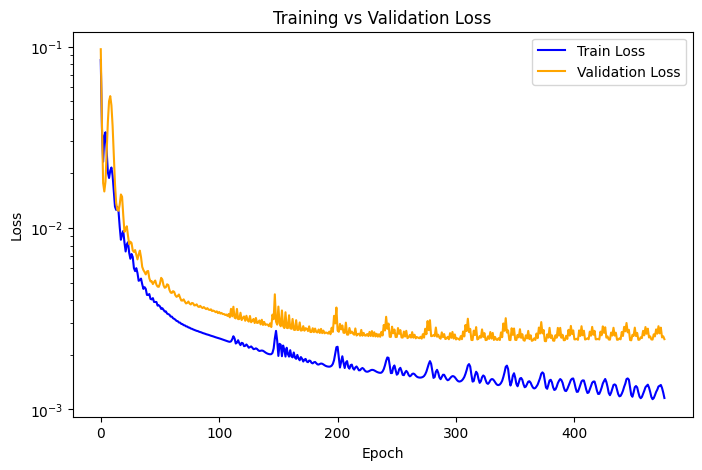

In [4]:
from nbeats_pytorch.model import NBeatsNet 

model = NBeatsNet(
    stack_types=("generic", "generic"),
    forecast_length=1,
    backcast_length=window_size,
    hidden_layer_units=128,
)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, val_losses = [], []
best_val_loss = float('inf')
stopping_counter = 0
early_stopping = True

num_epochs = 5000 
early_stopping_patience = 100

for epoch in range(num_epochs):
    # Training step
    model.train()
    optimizer.zero_grad()
    _, output = model(train_sequences)
    train_loss = criterion(output, train_targets)
    train_loss.backward()
    optimizer.step()
    
    # Validation step
    model.eval()
    with torch.no_grad():
        _, val_output = model(val_sequences)
        val_loss = criterion(val_output, val_targets)
    
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        stopping_counter = 0
    else:
        stopping_counter += 1
    
    if early_stopping and stopping_counter >= early_stopping_patience:
        print("Early stopping triggered!")
        break
        
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


# Prediction

In [5]:
test_sequences, test_targets = s.create_sequences(test_data, window_size)
test_sequences = torch.tensor(test_sequences, dtype=torch.float32)
test_targets = torch.tensor(test_targets, dtype=torch.float32)

# Initialize lists for storing predictions
online_predictions = []
actual_values = []

# Define online optimizer and loss function
online_optimizer = optim.Adam(model.parameters(), lr=1e-6)
criterion = nn.MSELoss()

# ======= 9. Online Prediction and Evaluation =======
for i in range(len(test_sequences)):
    x = test_sequences[i].unsqueeze(0)
    
    # Model inference
    model.eval()
    with torch.no_grad():
        pred = model(x)[1]  # Extract the forecast output
    online_predictions.append(pred.item())
    actual_values.append(test_targets[i].item())

    # Online learning step
    model.train()
    online_optimizer.zero_grad()
    pred_online = model(x)[1]  # Extract forecast again for training
    loss_online = criterion(pred_online, test_targets[i].unsqueeze(0))
    loss_online.backward()
    online_optimizer.step()

online_predictions_inv = scaler.inverse_transform(np.array(online_predictions).reshape(-1, 1)).flatten()
actual_values_inv = scaler.inverse_transform(np.array(actual_values).reshape(-1, 1)).flatten()

metrics_result = metrics.all_metrics(actual_values_inv, online_predictions_inv)
print("Evaluation Metrics:")
for metric, value in metrics_result.items():
    print(f"{metric}: {value:.4f}")


Evaluation Metrics:
MAE: 109.4766
MSE: 34336.5665
RMSE: 185.3013
R2: 0.8012
MAPE: 0.0128
sMAPE: 0.0127


# Animation

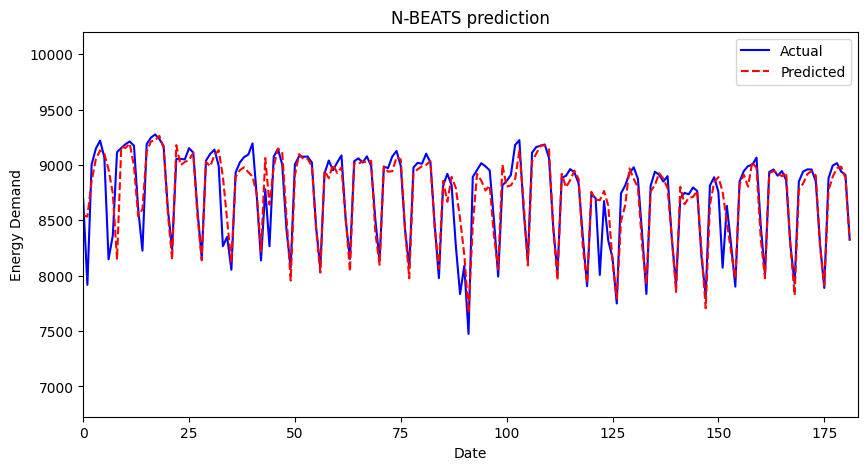

In [6]:
from datetime import datetime

test_dates = islas_dfs['Tenerife']['TIME_PERIOD_CODE'].values.reshape(-1,1)


fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlim(0, len(actual_values_inv))
ax.set_ylim(min(actual_values_inv) * 0.9, max(actual_values_inv) * 1.1)
ax.set_xlabel("Date")
ax.set_ylabel("Energy Demand")
ax.set_title("N-BEATS prediction")

actual_line, = ax.plot([], [], color='blue', label="Actual")
predicted_line, = ax.plot([], [], color='red', linestyle="dashed", label="Predicted")
ax.legend()

# Update function
def update(frame):
    actual_line.set_data(range(frame), actual_values_inv[:frame])
    predicted_line.set_data(range(frame), online_predictions_inv[:frame])

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(actual_values_inv), interval=50)

# Save video
ani.save("../results/nbeats_predictions.mp4", writer="ffmpeg", fps=30)

plt.show()